In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [3]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [4]:
df_test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

In [5]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])

y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_kaggle_way_old.csv', index=False)

In [6]:
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.274030
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.495530
                     BEVERAGES                   3000891  2414.541711
                     BOOKS                       3000892     0.438314
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   372.417153
                     PREPARED FOODS              3029396   107.843530
                     PRODUCE                     3029397  1273.316507
                     SCHOOL AND OFFICE SUPPLIES  3029398    44.945937
                     SEAFOOD                     3029399    18.946715

[28512 rows x 2 columns]

date         period[D]
store_nbr     category
family        category
id               int64
sales          float64
dtype: object

(array([17395., 17397., 17399., 17401., 17403., 17405., 17407., 17409.]),
 [Text(17395.0, 0, '2017-08-17'),
  Text(17397.0, 0, '2017-08-19'),
  Text(17399.0, 0, '2017-08-21'),
  Text(17401.0, 0, '2017-08-23'),
  Text(17403.0, 0, '2017-08-25'),
  Text(17405.0, 0, '2017-08-27'),
  Text(17407.0, 0, '2017-08-29'),
  Text(17409.0, 0, '2017-08-31')])

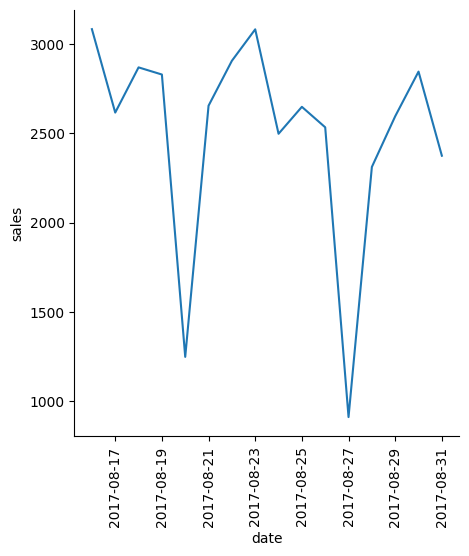

In [16]:
x=y_submit.reset_index()

x.date = x.date.astype(np.datetime64)

sns.relplot(data=x[(x['date']>='2017-08-16') & (x['store_nbr']=='1') & (x['family']=='GROCERY I')], x='date', y='sales', kind='line')
plt.xticks(rotation=90)

# sns.relplot(data=all_df[(all_df['date']>='2017-08-16') & (all_df['store_nbr']=='1') & (all_df['family']=='GROCERY I')], x='date', y='sales', kind='line')
# plt.xticks(rotation=90)
# plt.show()